## GeoAI

### Purpose

This notebook shows my process to identify a way to create input for geotechnical profiles out of raw CPT data. 

### General idea

We have a lot of raw CPT (Cone Penetration Test) data in Amsterdam, at least 5.000 CPTs all over the city. On special locations along the embankements of levee we have the need to create so called geotechnical profiles. Here's an example;



The normal process of creating such a profile is to get the CPT data, enhance it with borehole data (more specific data) and use the knowledge of a geological engineer to create the profile out of this data. 

The question I asked myself was; is it possible to do the same work using ML (machine learning) that is trained on data that we have? Next to CPTs we have some geotechnical profiles of the levees in Amsterdam so we do have labeled training data which is required for a supervised ML model. 

I am also interested in the question how this kind of classification would perform against existing CPT to soiltype correlations like Robertson or those given in CUR 162 or NEN5140. 

So there you have it.. the question was born and now I try to find the answers..

### Import the heavy stuff

As always, we start with the import of some Python libraries (including my own)

In [1]:
import sys, os, math
import pandas as pd
sys.path.append("D:\\Projects\\Python\\libraries\\") #using windows.. so have to 'hack' a little

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from bbgeolib.objects.gef import get_from_file
from bbgeolib.tools.gef import get_unit_weight_from_cpt, get_soilstress_from_cpt

ModuleNotFoundError: No module named 'bbgeolib'

### Creating the input data

For training a ML model we need labeled training data. I chose a part of a levee in Amsterdam for which we have 9 CPTs and a geotechnical profile. A CPT contains qc (cone pressure) and fs (friction) measurements which looks like this;



The data is actually stored in GEF files (a way to exchange this kind of data) which look like this;


So we have to find a way to say, this qc combined with this fs is equal to soil type x. In other words, our input is (at least) qc and fs, our output is the soilname.

Hey, we can do that! First let's hard code the input files we will use...

In [2]:
files = [
    'gefs\\E06-1441.GEF',
    'gefs\\E06-1443.GEF',
    'gefs\\E06-1444.GEF',
    'gefs\\E06-1445.GEF',
    'gefs\\E07-1107.GEF',
    'gefs\\E07-1109.GEF',
    'gefs\\E07-1110.GEF',
    'gefs\\E07-1112.GEF',
    'gefs\\E07-1113.GEF'
]   

Fortunately I have already written a script to read GEF files which results in a large Dataframe with depth, qc and fs columns. But for the soilnames I had to look at the geotechnical profile and use some kind of easy to process data. I decided to create a simple dictionary with the name of the GEF and the soillayer data like TOP,SOILNAME_1,TOP_OF_NEXT_SOILLAYER,SOILNAME_2;etc.. 

In [3]:
    soils = {
        'E06-1441':'99,OB,-0.6,KS,-4.0,HV,-6.0,KS,-6.7,WZ, -8.8,KM,-10.5,BV,-10.6,PZ,-13.3,KM,-14.3,PZ',
        'E06-1443':'99,OB,-0.9,KS,-4.0,HV,-6.2,KS,-6.9,WZ, -9.3,KM,-11.1,BV,-11.4,PZ,-13.7,KM,-15.1,PZ',
        'E06-1444':'99,OB,-1.0,KS,-3.9,HV,-5.9,KS,-6.2,WZ,-10.4,KM,-11.2,BV,-11.9,PZ,-14.2,KM',
        'E06-1445':'99,OB,-1.0,KS,-4.1,HV,-6.0,KS,-6.2,WZ,-10.5,KM,-11.2,BV,-12.5,PZ,-14.6,KM,-15.7,PZ',
        'E07-1107':'99,OB,-0.6,KS,-3.2,HV,-6.2,KS,-6.9,WZ, -9.8,KM,-11.6,BV,-12.3,PZ,-14.7,KM',
        'E07-1109':'99,OB,-0.4,KS,-2.7,HV,-5.8,KS,-6.1,WZ,-10.2,KM,-12.0,BV,-12.4,PZ,-14.7,KM,-15.7,PZ',
        'E07-1110':'99,OB,-0.5,KS,-3.5,HV,-6.4,KS,-6.8,WZ, -9.9,KM,-11.2,BV,-11.6,KM,-17.7,PZ',
        'E07-1112':'99,OB,-0.9,KS,-3.6,HV,-6.4,KS,-6.8,WZ, -9.9,KM,-10.9,BV,-11.2,KM,-12,BV,-12.6,PZ,-14.6,KM,-17.2,PZ',
        'E07-1113':'99,OB,-0.9,KS,-4.2,HV,-6.2,KS,-6.4,WZ, -9.8,KM,-10.5,BV,-10.8,KM,-11.9,BV,-12.3,PZ,-14.6,KM,-17,PZ'
    }

Just to be clear; the first line (E06-1441) should be read as;

* from +99 to -0.6 the soiltype is OB
* from -0.6 to -4.0 the soiltype is KS

etc..

For a ML model we need to create a large input matrix. I like to put my inputs in a matrix called X and the results in a list called y. So let's do this.

In [4]:
def create_input():
    """use the given data to create input for a ML model"""
    dfs = []    
    for file in files:
        # read the file
        gef = get_from_file(file)
        # check the name, we need it for the soils dictionary
        name = os.path.basename(gef.filename).split('.')[0]
        # oh yes, I already anticipated that we would like a Dataframe of the CPT data..
        df = gef.as_dataframe()
        # add a column with the soilname that we do not know yet
        df['soilname'] = 'unknown'
        # get the soils for this CPT and create a list with [soilname, top, bottom]
        args = soils[name].split(',')
        soilnames = args[1::2]
        tops = [float(a) for a in args[0::2]]
        bottoms = tops[1:] 
        bottoms.append(-99) 
        # use Pandas filter to assign the right soilname to the qc/fs combination
        for soilname, top, bottom in zip(soilnames,tops,bottoms):  
            df.loc[(df['depth']<=top) & (df['depth']>=bottom), 'soilname']=soilname
        # only use the interesting columns for the result
        df = df[['depth', 'qc','fs', 'soilname']]
        dfs.append(df)
        
    # combine all gefs to one large matrix
    return pd.concat(dfs)  

Let's have a look at the result...

In [5]:
df = create_input()
print(df.head())
print(df.shape)

   depth      qc        fs soilname
0   0.32  0.2224  0.000001       OB
1   0.31  0.2265  0.000001       OB
2   0.30  0.3876  0.000001       OB
3   0.29  0.3876  0.000001       OB
4   0.28  0.4330  0.000001       OB
(15286, 4)


Right, 15286 rows of qc / fs values. That's a nice start. 

### A little datascience trick

There are a lot of things that need to be done with the data. The dimensions of qc and fs are really different so we have to find a way to weigh them equally in the model. This is known as data normalization. Let's do just that.

In [6]:
df['qcn']=(df['qc']-df['qc'].min())/(df['qc'].max()-df['qc'].min())
df['fsn']=(df['fs']-df['fs'].min())/(df['fs'].max()-df['fs'].min())

print("old: qcmax=%f, fsmax=%f"%(df['qc'].max(), df['fs'].max()))
print("new: qcmax=%f, fsmax=%f"%(df['qcn'].max(), df['fsn'].max()))

old: qcmax=40.021000, fsmax=0.297600
new: qcmax=1.000000, fsmax=1.000000


That's better. Let's plot the data to get an idea of what it looks like. So far this is 2D data so that is nice for the human eye. However, before we plot the data we need a way to represent the soilnames by a number. This is a common technique in ML so we have loads of options to do this. I use the SKLearn library method for this.

In [7]:
le = LabelEncoder()
df['class'] = le.fit_transform(df['soilname'])
print(df.head())

   depth      qc        fs soilname       qcn  fsn  class
0   0.32  0.2224  0.000001       OB  0.005532  0.0      4
1   0.31  0.2265  0.000001       OB  0.005635  0.0      4
2   0.30  0.3876  0.000001       OB  0.009660  0.0      4
3   0.29  0.3876  0.000001       OB  0.009660  0.0      4
4   0.28  0.4330  0.000001       OB  0.010795  0.0      4


Just so you know, if you ever want to translate the number back to the soilname.. that's taken care of!

In [8]:
print(le.classes_)

['BV' 'HV' 'KM' 'KS' 'OB' 'PZ' 'WZ']


Ok, let's plot this using the beautiful matplotlib library. Note the we use our own color scheme based on a discrete number of soiltypes. If we wouldn't do this the legend would show a beautiful but less functional scalebar. Also note that using the _ = ax.blabla code is used to supress the text output of the command.

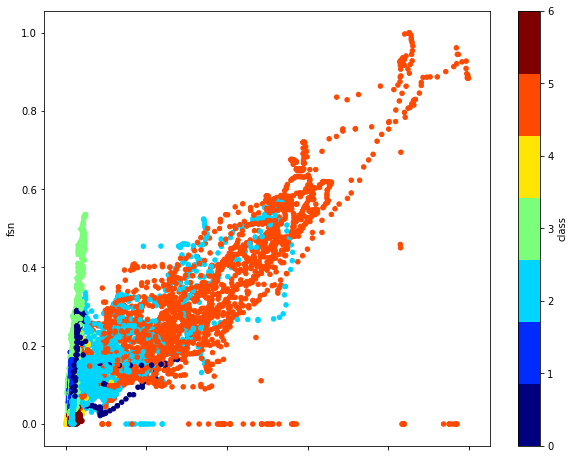

In [9]:
N = len(le.classes_)
cmap = plt.cm.get_cmap('jet', N) 
ax = df.plot.scatter(x = 'qcn', y = 'fsn', c= 'class', cmap=cmap, figsize=(10,8))
_ = ax.set(xlabel='qcn', ylabel='fsn')

###  Take a break!

Ok, let's take a break and look at what we got so far. This plot shows the distribution of about 15.000 qc / fs points and their soiltype. I note a few things;

* at fsn close to 0. we find a lot of points to the right.. they look like errors
* the distribution is quite crowded at the bottomleft and gets thinner and thinner at the topright. It would be easier to identify similar regions if the regions where not as dense as they are now.

### Classification algorithms

Anyway, we have a starting point so let's look at some simple classification algorithms. As the name implies a classification algorithm tries to find a relation between some values (in our case qc and fs) and the class (in our case the soilname or for now the soilname number). There are unsupervised algorithms (KMeans / Guassian Mixture) and supervised ones (like the SGDClassifier). The difference is that unsupervised algorithms just try to classify the points without knowing anything about the labels. In other words they just try to group the data in clusters of qc/fs values but they have no idea which soiltype they belong to (and they don't care!).

Let's start of with the unsupervised algorithms KMeans and Guassian mixture.

First we need the input data which is the qcn and fsn data that we created;

In [10]:
X = df[['qcn', 'fsn']].values

Although the unsupervised algorithms do not know anything about the soiltypes we do know that we have (N=7) of them so that is useful to tell the algorithm (n_clusters=N).

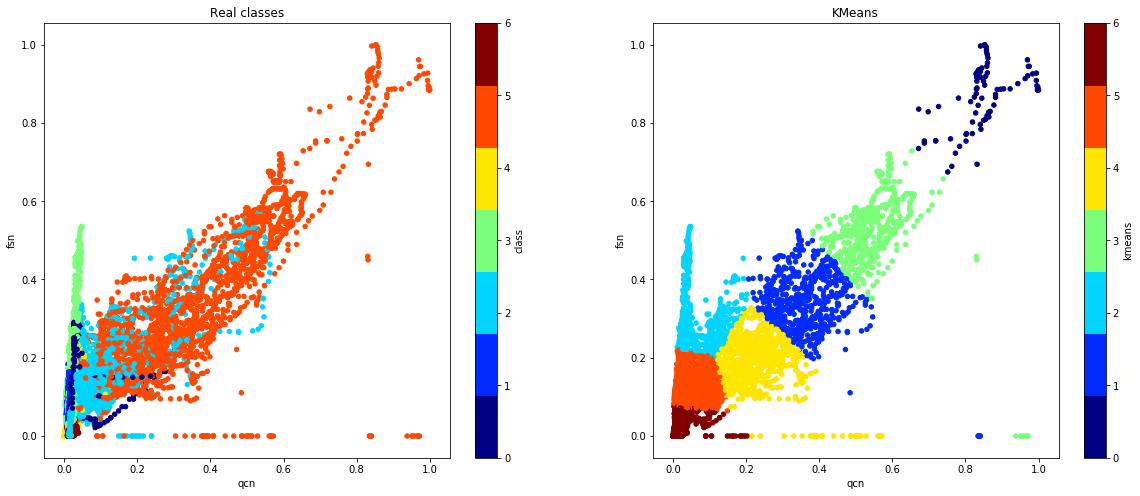

In [11]:
kmeans = KMeans(n_clusters=N, init='random', max_iter=100).fit(X)
df['kmeans'] = kmeans.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(20,8))
axes[1].set_title('KMeans')
axes[0].set_title('Real classes')
df.plot.scatter(ax=axes[1], x = 'qcn', y = 'fsn', c= 'kmeans', cmap=cmap)
# also plot the original data
_ = df.plot.scatter(ax=axes[0], x = 'qcn', y = 'fsn', c= 'class', cmap=cmap)

### KMeans output

So what do we see now.. KMeans is nice but limited so far. Like you should expect because KMeans simply uses the distance between the center of the cluster and the points. Overlapping points will always be classified to the nearest cluster centre which leads to these ellipses of classes. 

Gaussian mixture uses statistical reasoning to allow points to be a little off the centre of the cluster. This is a nice way for some improvement. Let's fill the plot with this algorithm as well... 

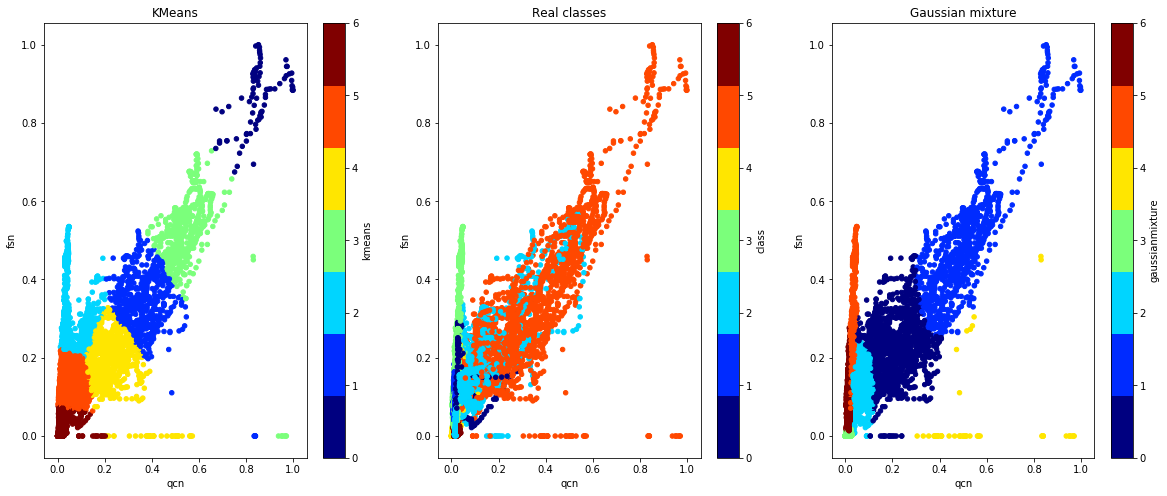

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
df.plot.scatter(ax=axes[0], x = 'qcn', y = 'fsn', c= 'kmeans', cmap=cmap)
df.plot.scatter(ax=axes[1], x = 'qcn', y = 'fsn', c= 'class', cmap=cmap)
axes[0].set_title('KMeans')
axes[1].set_title('Real classes')
axes[2].set_title('Gaussian mixture')
df['gaussianmixture'] = GaussianMixture(n_components=N).fit(X).predict(X)
_ = df.plot.scatter(ax=axes[2], x = 'qcn', y = 'fsn', c= 'gaussianmixture', cmap=cmap)

### Guassian mixture output

This (on the right) looks a lot better! The algorithm was able to correctly identify some of the outliers. However.. this still is an unsupervised algorithm so there is no way to check how accurate this was (unless we find a way to name the clusters the algorithm found to our original soil layers but this is only possible if our data is 2D or maybe 3D and not really what the algorithm is meant for.. we will skip that for now).

We want our accuracy! So let's get on with the supervised algorithm.

### SGDClassifier

The SGD classifier (stochastic gradient descent) is a little complicated to understand if you're not into ML. The easiest way to try and grasp the concept is to think of the algorithm trying to minimize the errors it makes by iterating over and over and looking for the best direction. Like putting a ball on top of a hill and letting it roll to the lowest point (which hopefully is the global minimum and not a local minimum). But enough of that, try some Udemy courses if you're interested.

There are some differences in the usage of a supervised algorithm which boil down to using the right set of hyper parameters that define how the model will be trained. This is mostly just trying different combinations and looking for the accuracy to improve.. so don't be intimidated by people calling this science ;-)

Also note that if you want to use a supervised model, you need the labels! In our case this is easy..

In [13]:
y = df['class'].values

So now we have the input (X) and output (y), let's train the model...

In [14]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-4, class_weight= 'balanced')
clf.fit(X,y)
df['sgdclassifier'] = clf.predict(X)

That was easy! Let's have a look at the result...

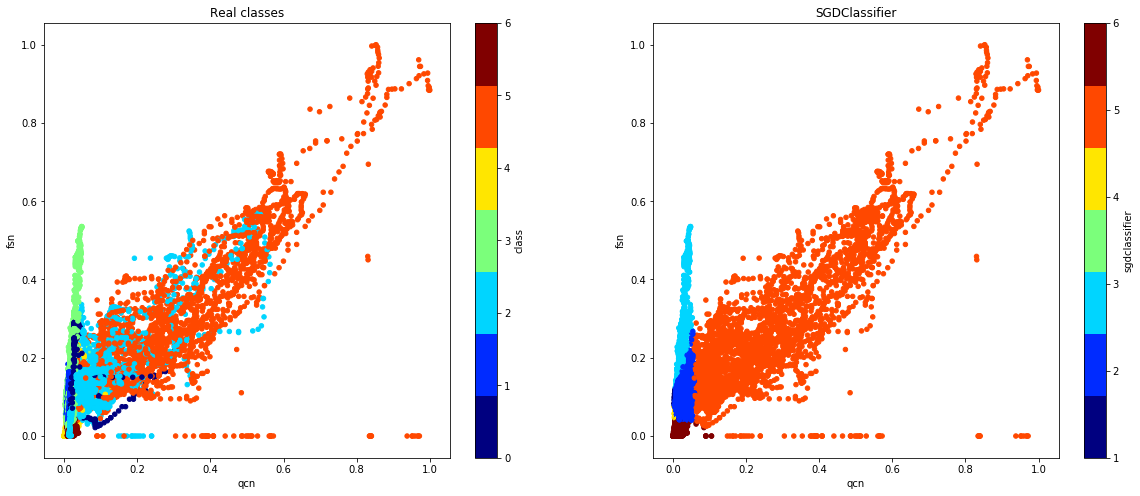

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
axes[1].set_title('SGDClassifier')
axes[0].set_title('Real classes')
df.plot.scatter(ax=axes[1], x = 'qcn', y = 'fsn', c= 'sgdclassifier', cmap=cmap)
# and also plot the original data
_ = df.plot.scatter(ax=axes[0], x = 'qcn', y = 'fsn', c= 'class', cmap=cmap)

Oh dear, definitely room for improvement.. let's check the accuracy..

In [16]:
print("Accuracy SGDClassifier:", accuracy_score(y, df['sgdclassifier']))

Accuracy SGDClassifier: 0.48004710192332856


Not too good is it! And there are reasons for it. We probably have skewed data (which means that we might have little data about soiltype X and an abundance of data about soil layer Y so the model might prefer X) but we did use balanced in the algorithm so that should be covered.. what's more?... 

### A little datascience trick

If we were able to spread the points al little more it would be easier for the algorithm to find the boundaries of the points. Let's try this by using the log of the qc and fs..

In [17]:
df2 = create_input()
df2['qc'] = df2['qc'].apply(lambda x: math.log(x))
df2['fs'] = df2['fs'].apply(lambda x: math.log(x))
df2['qcn']=(df2['qc']-df2['qc'].min())/(df2['qc'].max()-df2['qc'].min())
df2['fsn']=(df2['fs']-df2['fs'].min())/(df2['fs'].max()-df2['fs'].min())
df2['class'] = le.fit_transform(df2['soilname'])

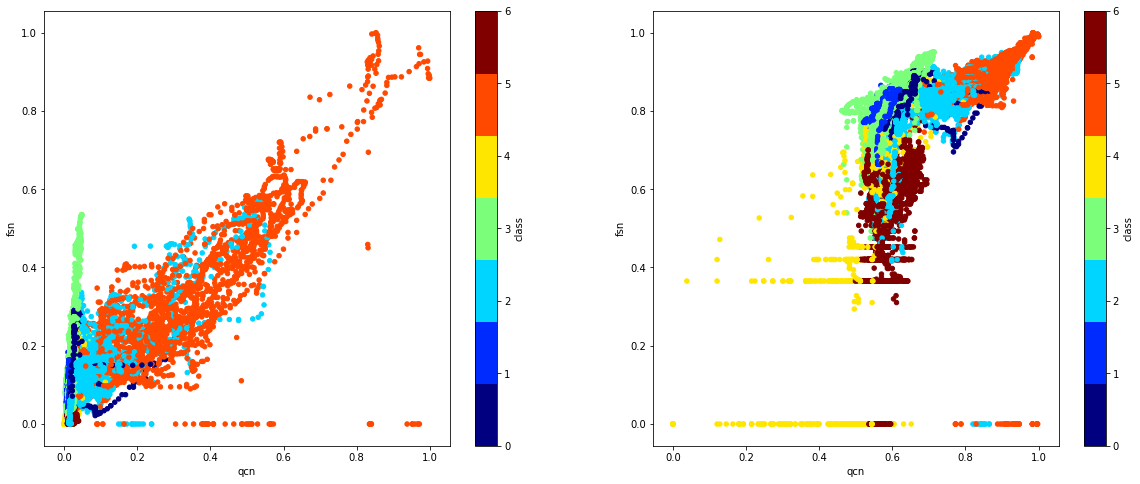

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
df.plot.scatter(ax=axes[0], x = 'qcn', y = 'fsn', c= 'class', cmap=cmap)
_ = df2.plot.scatter(ax=axes[1], x = 'qcn', y = 'fsn', c= 'class', cmap=cmap)

That looks better! Left is the original qc/fs and right we see the easier to see distribution of the log(qc)/log(fs) distribution. The yellow points are finally visible. But do note the strange points at fsn=0.. that will not improve our accuracy and is probaly an error. We will remove those points as well and then retrain the model and recalculate the accuracy.

In [20]:
df2= df2[df2['fsn']>0.1]
X = df2[['qcn', 'fsn']].values
y = df2['class'].values
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-4, class_weight= 'balanced')
clf.fit(X,y)
df2['sgdclassifier'] = clf.predict(X)
print("Accuracy SGDClassifier:", accuracy_score(y, df2['sgdclassifier']))

Accuracy SGDClassifier: 0.5974783716719201


That's better.. 60%-ish.. not fully useable and not the increase I hoped for but getting there.. let's plot the data again...

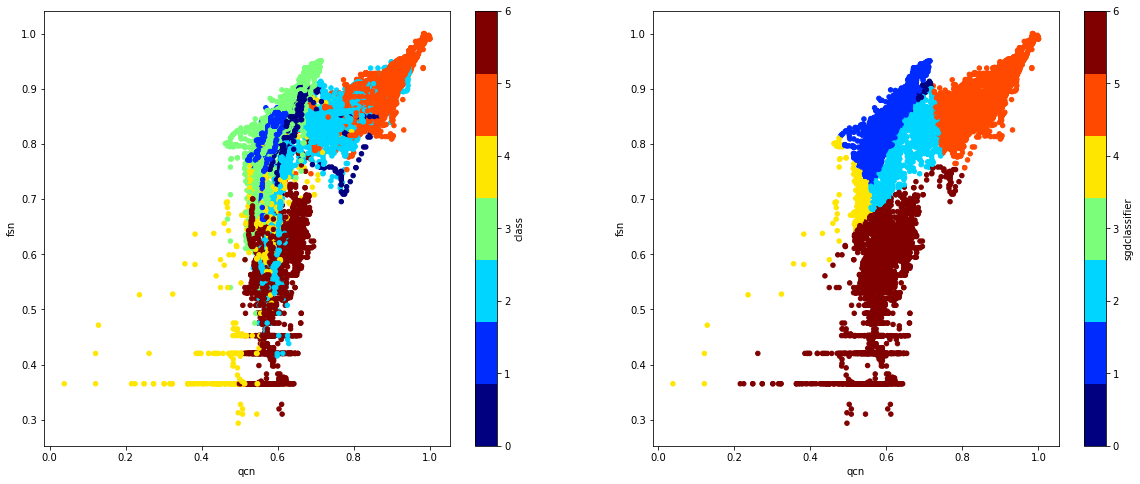

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
df2.plot.scatter(ax=axes[0], x = 'qcn', y = 'fsn', c= 'class', cmap=cmap)
_ = df2.plot.scatter(ax=axes[1], x = 'qcn', y = 'fsn', c= 'sgdclassifier', cmap=cmap)


You still see that points that are overlapped (like the yellow and light blue points in the brown area) will not be recognized correctly. I agree with the machine because if I had to draw some kind of line around the areas it would probably be close to what I see here. There are simply too little features (qc / fs) to make the right choice. We have to add a new dimension, think about it.. if we would plot the data in 3 dimensions it might be easier to make a distinction between the clusters.. (note that I say might because this is not always the case!).

### Domain knowledge

So, what's next? We could try and tune the hyperparameters, we could (and actually should!) look at creating test and validation sets etc. but this is also a good moment to think about implementing some domain knowledge. So far we have only looked at a relation between the cone pressure, cone friction and the soil layer.. but we know that depth also has a role in this relation. Look at the geotechnical profile. Soil type OB can only be found on the top layers, as geotechnical engineers we know that this is the case. The same applies to the soil PZ.. this can not be found as a top layer and will always be below a possible BV layer. 

This is where ML shines.. we could simply add the depth and we get multidimensional data. Ok, it was 2D (qc / fs) and now 3D (qc / fs / depth) but if we were to think of more so called features we could make it N-dimensional and ML would still be able to make predictions.. try that with standard statistics!

We could simply add the depth of the measurement to the dataset but I chose another, a little more complicated, way. I have to say that I did not look at what would happen if I simply added the depth so feel free! I have added the so called total soil pressure using some correlations that I found in literature. This value will increase with depth.

Now the process of getting the required training data is a little more complicated but still usable (note that I rely on a function in my personal library to calculate the new parameter 'soil stress' or sv.

In [22]:
def create_input_with_soilstress():
    dfs = []    
    for file in files:
        gef = get_from_file(file)
        name = os.path.basename(gef.filename).split('.')[0]
        df = gef.as_dataframe()
        df = get_soilstress_from_cpt(gef)
        df['soilname'] = 'unknown'
        args = soils[name].split(',')
        soilnames = args[1::2]
        tops = [float(a) for a in args[0::2]]
        bottoms = tops[1:]
        bottoms.append(-99)
        for soilname, top, bottom in zip(soilnames,tops,bottoms):  
            df.loc[(df['depth']<=top) & (df['depth']>=bottom), 'soilname']=soilname
        df = df[['depth', 'qc','fs', 'sv', 'soilname']]
        dfs.append(df)
        
    return pd.concat(dfs)  

Accuracy SGDClassifier: 0.7348266380524445


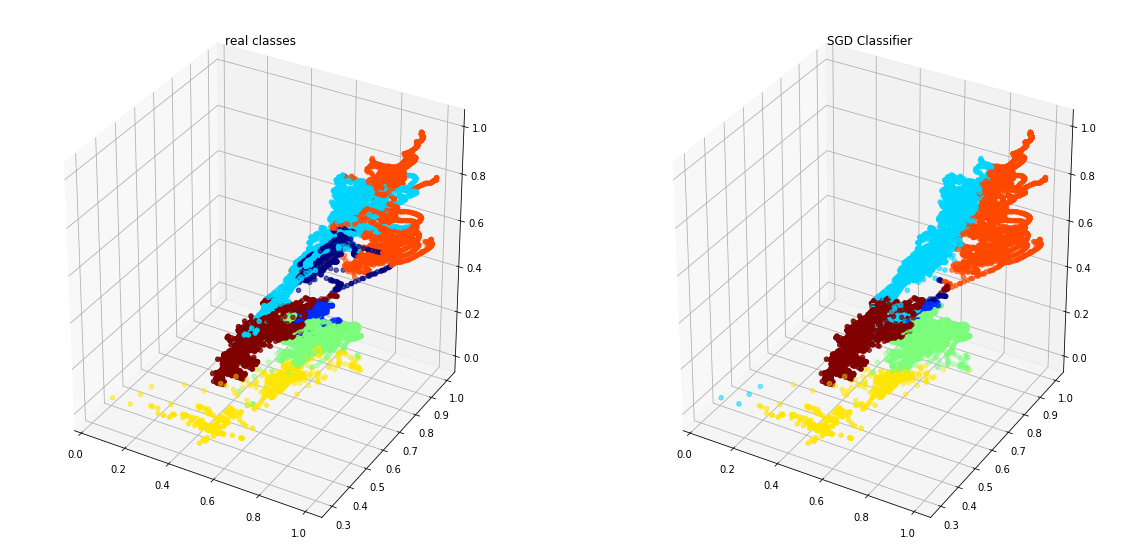

In [23]:
df3 = create_input_with_soilstress()

df3['qc'] = df3['qc'].apply(lambda x: math.log(x))
df3['fs'] = df3['fs'].apply(lambda x: math.log(x))
df3['qcn']=(df3['qc']-df3['qc'].min())/(df3['qc'].max()-df3['qc'].min())
df3['fsn']=(df3['fs']-df3['fs'].min())/(df3['fs'].max()-df3['fs'].min())
df3['svn']=(df3['sv']-df3['sv'].min())/(df3['sv'].max()-df3['sv'].min())

# remove noise
df3 = df3[df3['fsn']>0.1]

le = LabelEncoder()
df3['class'] = le.fit_transform(df3['soilname'])

X = df3[['qcn', 'fsn', 'svn']].values
y = df3['class'].values

# plot real data
N = len(le.classes_)
fig = plt.figure(figsize=(20,10))
cmap = plt.cm.get_cmap('jet', N)
ax0 = fig.add_subplot(121,projection='3d')
cmap = plt.cm.get_cmap('jet', N) #6 discrete colors
ax0.set_title('real classes')
ax0.scatter3D(df3['qcn'], df3['fsn'],df3['svn'], c=df3['class'], cmap=cmap)

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-4, class_weight= 'balanced')
df3['sgdclassifier'] = clf.fit(X,y).predict(X)
ax1 = fig.add_subplot(122,projection='3d')
ax1.set_title('SGD Classifier')
print("Accuracy SGDClassifier:", accuracy_score(y, df3['sgdclassifier']))
_ = ax1.scatter3D(df3['qcn'], df3['fsn'],df3['svn'], c=df3['sgdclassifier'], cmap=cmap)

Wow.. 76%, that is a nice increase! 

### Summing it up

We are not done yet.. we have to be better data scientists and **definitely** create a test and validation set. We have to look at the distribution of the data but so far we did a nice job.

You might ask yourself.. what's the use of what you did? And that is a good question.. I sometimes ask this question after I finish the work ;-) . In my opinion this would be a great way to train local soil classifiers. We do have empirical correlations like Robertson that are actually quite good but for instance in Amsterdam we do have some specific soil types and wishes for our classification. 

I will continue to study and develop this model to see if we can create a ML algorithm that is able to generate geotechnical profiles that are close to those made by a geotechnical engineer. This could improve our workflow because a large part of our work is already probabilistic so a probabilistic geotechnical profile is not a bad idea.

### Ideas, comments, anything?

This notebook is the result of a days work (no, not my libraries, they took a little more time ;-) so it must contain errors, there should also be ways to improve the data / algorithms so I would love to hear your ideas and comments. Please send them to breinbaasnl@gmail.com / rob.van.putten@waternet.nl .

Regards,
Rob